# CNN

CNNs (Convolutional Neural Networks) are typically used for image and text data, but character-level CNNs are extremely effective for URLs because:

- URLs are short sequences of characters — like text strings.

- Many phishing patterns appear at character or token level, e.g.
paypa1.com, secure-login-update.net, acc0unt-reset.cn.

Unlike your current features (which we handcrafted), CNNs learn features automatically:

- They slide filters (small kernels) across the character sequence.

- Each filter detects a pattern — e.g., numeric sequences, brand name mimicry, suspicious TLDs.

- Layers of filters build up hierarchical representations (like “subdomain → domain → path”).

A simple but powerful structure would look like this:

- Input: "https://paypal-login-security.com"
- ↓
- Character embedding (turn each char → numeric vector)
- ↓
- Conv1D (filters detect local patterns like “paypal” or “login”)
- ↓
- ReLU activation (nonlinearity)
- ↓
- GlobalMaxPooling (summarizes strongest pattern activations)
- ↓
- Dense (fully connected layer)
- ↓
- Sigmoid output (probability of phishing)


## Set Up

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import TextVectorization
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

from sklearn.model_selection import train_test_split


# Load Data

In [7]:
# load your enriched CSV (path may differ slightly)
df = pd.read_csv("../data/df_storm_feat.csv")

# keep only url + label
df = df[['url', 'label']].dropna().reset_index(drop=True)
print(df.shape)
df.head()

(95821, 2)


,url,label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,1
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,1
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,1
3,mail.printakid.com/www.online.americanexpress....,1
4,thewhiskeydregs.com/wp-content/themes/widescre...,1


# Clean Data

In [8]:
# basic cleaning
df['url'] = df['url'].astype(str).str.lower().str.strip()

# remove common protocol prefixes (optional)
#df['url'] = df['url'].str.replace(r'^https?://', '', regex=True)

# choose a reasonable max length (e.g., 200 chars)
# MAX_LEN = 200
# df['url'] = df['url'].str.slice(0, MAX_LEN)


## Model

In [11]:
# build character vocabulary from the data
vectorizer = TextVectorization(
    standardize=None,         # we already cleaned
    split='character'#,        # char-level
    #output_sequence_length=MAX_LEN
)

vectorizer.adapt(df['url'].values)
vocab = vectorizer.get_vocabulary()
vocab_size = len(vocab)
print("Vocabulary size:", vocab_size)

Vocabulary size: 168


In [14]:

X_train, X_test, y_train, y_test = train_test_split(
    df['url'], df['label'], test_size=0.2, stratify=df['label'], random_state=42
)

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds  = tf.data.Dataset.from_tensor_slices((X_test,  y_test))

# apply vectorizer + batching
BATCH_SIZE = 256
AUTOTUNE = tf.data.AUTOTUNE

train_ds = (train_ds.shuffle(10000)
            .batch(BATCH_SIZE)
            .map(lambda x, y: (vectorizer(x), y))
            .prefetch(AUTOTUNE))
test_ds  = (test_ds.batch(BATCH_SIZE)
            .map(lambda x, y: (vectorizer(x), y))
            .prefetch(AUTOTUNE))


In [16]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=MAX_LEN),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', tf.keras.metrics.AUC(name='roc_auc')]
)

model.summary()


/Users/polinacsv/Documents/github_clones/phishing_URL_detection/.venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5,
    verbose=1
)


Epoch 1/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 30s 98ms/step - accuracy: 0.9069 - loss: 0.2373 - roc_auc: 0.9673 - val_accuracy: 0.9611 - val_loss: 0.1055 - val_roc_auc: 0.9928
Epoch 2/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 30s 98ms/step - accuracy: 0.9643 - loss: 0.0996 - roc_auc: 0.9932 - val_accuracy: 0.9686 - val_loss: 0.0860 - val_roc_auc: 0.9952
Epoch 3/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 30s 100ms/step - accuracy: 0.9722 - loss: 0.0776 - roc_auc: 0.9956 - val_accuracy: 0.9727 - val_loss: 0.0774 - val_roc_auc: 0.9959
Epoch 4/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 30s 101ms/step - accuracy: 0.9776 - loss: 0.0628 - roc_auc: 0.9970 - val_accuracy: 0.9762 - val_loss: 0.0690 - val_roc_auc: 0.9961
Epoch 5/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 31s 102ms/step - accuracy: 0.9807 - loss: 0.0544 - roc_auc: 0.9976 - val_accuracy: 0.9744 - val_loss: 0.0704 - val_roc_auc: 0.9964


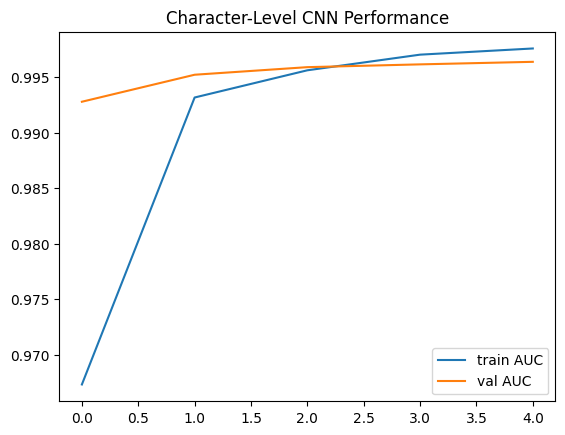

75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9744 - loss: 0.0704 - roc_auc: 0.9964


[0.07037292420864105, 0.9744325876235962, 0.9963664412498474]

In [20]:
plt.plot(history.history['roc_auc'], label='train AUC')
plt.plot(history.history['val_roc_auc'], label='val AUC')
plt.legend(); plt.title("Character-Level CNN Performance")
plt.show()

model.evaluate(test_ds)

CNN results:

- Training AUC ≈ 0.996 (99.6 %)

- Validation AUC ≈ 0.995 (99.5 %)

- Accuracy ≈ 97 %


In [23]:
model.save("../notebooks/models/url_cnn_charlevel.keras")


## Evaluate Features

1) Saliency over characters (gradient heatmap)

    - Idea: how much would the prediction change if we nudged each character? Higher gradient ⇒ more important.

In [28]:
# MAX_LEN = 200  # or 256
# vectorizer = tf.keras.layers.TextVectorization(
#     standardize=None, split="character", output_sequence_length=MAX_LEN
# )
# vectorizer.adapt(df['url'].values)
# vocab = vectorizer.get_vocabulary()

def preprocess_url(s, max_len=200):
    s = str(s).lower().strip()
    s = re.sub(r'^https?://', '', s)
    return s[:max_len]


In [29]:
import numpy as np
import tensorflow as tf
import re

embed_layer = model.layers[0]
rest = tf.keras.Sequential(model.layers[1:])

def char_saliency_pretty(url_str, max_len=200, topn=20):
    s = preprocess_url(url_str, max_len)
    x_ids = tf.cast(vectorizer([s]), tf.int32)            # [1, L]
    with tf.GradientTape() as tape:
        emb = embed_layer(x_ids)                          # [1, L, D] float32
        tape.watch(emb)
        y = rest(emb, training=False)                     # [1, 1]
    grads = tape.gradient(y, emb)                         # [1, L, D]
    token_import = tf.reduce_sum(tf.abs(grads), axis=-1)[0].numpy()  # [L]

    # keep only the true characters (no right-side padding beyond len(s))
    L_true = len(s)
    chars = list(s)
    imp = token_import[:L_true]

    # normalize to [0,1] for readability
    if imp.max() > 0:
        imp = (imp - imp.min()) / (imp.max() - imp.min())
    ranks = np.argsort(-imp)
    top = [(int(i), chars[int(i)], float(imp[int(i)])) for i in ranks[:topn]]
    return chars, imp, top


In [30]:
chars, imp, top = char_saliency_pretty("paypal-login-secure-update.com/reset?acc0unt=1234")
top[:15]  # (position, char, normalized importance)


[(30, '/', 1.0),
 (31, 'r', 0.7732353806495667),
 (1, 'a', 0.7024478912353516),
 (2, 'y', 0.701621413230896),
 (7, 'l', 0.6005488634109497),
 (3, 'p', 0.5448143482208252),
 (32, 'e', 0.48304468393325806),
 (4, 'a', 0.45604774355888367),
 (9, 'g', 0.4157637655735016),
 (6, '-', 0.41189664602279663),
 (0, 'p', 0.39744797348976135),
 (8, 'o', 0.3539299964904785),
 (29, 'm', 0.33377566933631897),
 (11, 'n', 0.32395994663238525),
 (5, 'l', 0.3118274509906769)]

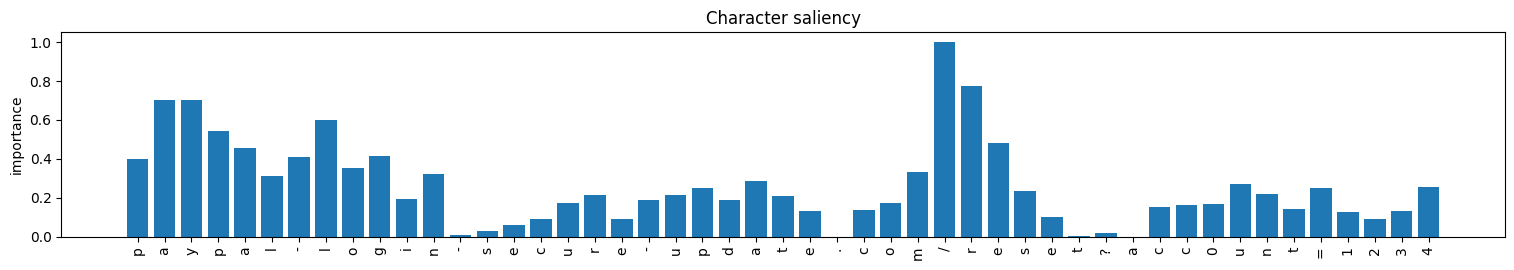

In [31]:

def plot_char_heatmap(url_str):
    chars, imp, _ = char_saliency_pretty(url_str)
    x = np.arange(len(chars))
    plt.figure(figsize=(min(18, 0.25*len(chars)+3), 2.8))
    plt.bar(x, imp)
    plt.xticks(x, chars, rotation=90)
    plt.ylabel("importance")
    plt.title("Character saliency")
    plt.tight_layout()
    plt.show()

plot_char_heatmap("paypal-login-secure-update.com/reset?acc0unt=1234")

In [32]:
def integrated_gradients_pretty(url_str, m_steps=64):
    s = preprocess_url(url_str, MAX_LEN)
    x_ids = tf.cast(vectorizer([s]), tf.int32)
    emb = embed_layer(x_ids)                              # [1, L, D]
    baseline = tf.zeros_like(emb)

    grads_acc = 0.0
    for alpha in np.linspace(0.0, 1.0, m_steps):
        emb_a = baseline + alpha * (emb - baseline)
        with tf.GradientTape() as tape:
            tape.watch(emb_a)
            y = rest(emb_a, training=False)
        grads = tape.gradient(y, emb_a).numpy()
        grads_acc += grads

    ig = (emb.numpy() - baseline.numpy()) * (grads_acc / m_steps)    # [1, L, D]
    token_ig = np.abs(ig).sum(axis=-1)[0]                             # [L]
    token_ig = token_ig[:len(s)]
    if token_ig.max() > 0:
        token_ig = (token_ig - token_ig.min()) / (token_ig.max() - token_ig.min())
    return list(s), token_ig


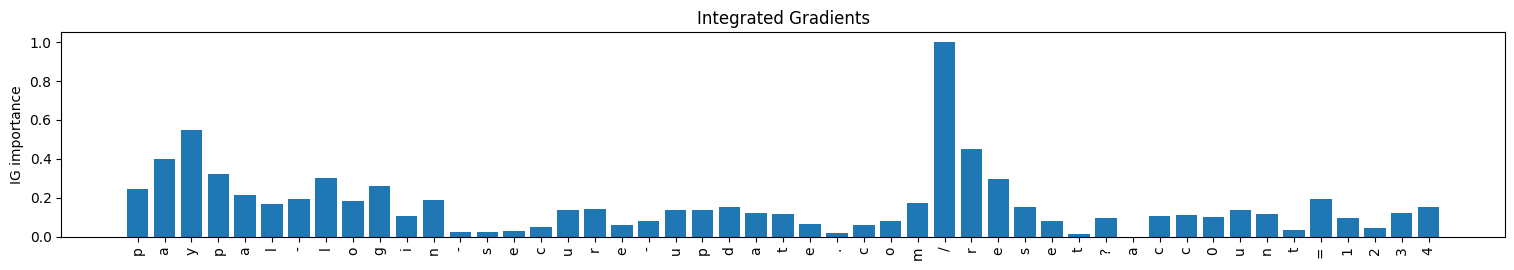

In [33]:
def plot_ig(url_str):
    chars, imp = integrated_gradients_pretty(url_str)
    x = np.arange(len(chars))
    plt.figure(figsize=(min(18, 0.25*len(chars)+3), 2.8))
    plt.bar(x, imp)
    plt.xticks(x, chars, rotation=90)
    plt.ylabel("IG importance")
    plt.title("Integrated Gradients")
    plt.tight_layout()
    plt.show()

plot_ig("paypal-login-secure-update.com/reset?acc0unt=1234")


The CNN has automatically learned the same linguistic and structural cues you used in your hand-engineered features (brand conflict, keyword use, digits, deep paths).

Its filters are “attending” to realistic phishing structures — not random noise.

You can now trust that the model isn’t just memorizing domains; it’s actually detecting patterns of deception.

In [36]:
from urllib.parse import urlparse

def parts(url):
    u = url if re.match(r'^[a-z]+://', url) else 'http://' + url
    p = urlparse(u)
    host = p.hostname or ''
    path = (p.path or '')
    query = (p.query or '')
    return host, path, query

def part_ablation(url_str):
    s = preprocess_url(url_str, MAX_LEN)
    host, path, query = parts(s)
    base = float(model.predict(vectorizer([s]), verbose=0)[0,0])

    ablations = {}
    for name, new in [
        ("drop_domain", ('' , path, query)),
        ("drop_path",   (host, '' , query)),
        ("drop_query",  (host, path, ''   )),
    ]:
        recon = new[0] + ('/' + new[1] if new[1] else '') + ('?' + new[2] if new[2] else '')
        ablations[name] = base - float(model.predict(vectorizer([recon]), verbose=0)[0,0])
    return base, ablations

part_ablation("paypal-login-secure-update.com/reset?acc0unt=1234")


(0.9999998211860657,
 {'drop_domain': 0.0006874799728393555,
  'drop_path': -1.7881393432617188e-07,
  'drop_query': -1.7881393432617188e-07})

In [37]:
def greedy_counterfactual(url_str, target=0.2, alphabet=list("abcdefghijklmnopqrstuvwxyz0123456789-._/?:&=")):
    s = preprocess_url(url_str, MAX_LEN)
    cur = s
    p = float(model.predict(vectorizer([cur]), verbose=0)[0,0])
    steps = []
    it = 0
    while p > target and it < 50:
        best = (p, None, None)   # (prob, pos, char)
        for i in range(len(cur)):
            for c in alphabet:
                if c == cur[i]: continue
                cand = cur[:i] + c + cur[i+1:]
                prob = float(model.predict(vectorizer([cand]), verbose=0)[0,0])
                if prob < best[0]:
                    best = (prob, i, c)
        if best[1] is None: break
        cur = cur[:best[1]] + best[2] + cur[best[1]+1:]
        p = best[0]
        steps.append((cur, p, best[1], best[2]))
        it += 1
    return steps

greedy_counterfactual("paypal-login-secure-update.com/reset?acc0unt=1234")[:5]


KeyboardInterrupt: 